# MotionTag Data Challenge

---
# init

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

PROJECT_ROOT = 'motiontag_challenge'

cur_dir = os.getcwd()
if os.path.basename(cur_dir) != PROJECT_ROOT and PROJECT_ROOT in cur_dir:
    proj_dir = os.path.join(cur_dir.split(PROJECT_ROOT)[0], PROJECT_ROOT)
    os.chdir(proj_dir)
print(f'current directory: {os.getcwd()}')

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
sys.path.insert(0, os.path.join(os.getcwd(), 'config'))

current directory: /Users/lucianionescu/coding/motiontag_challenge


---
# imports

### packages

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import folium
from matplotlib import pyplot as plt

from config.constants import CRS_BERLIN
from motiontag_challenge.filter import compute_velocity
from config.data_columns import Columns
from motiontag_challenge.request import send_request
from motiontag_challenge.tools.map import show_map
from motiontag_challenge.tools.ml_evaluation import print_evaluation
from motiontag_challenge.tools.etl import get_analysis_data_set, create_geopandas

### data load

In [3]:
data = get_analysis_data_set()
data.head()

,id,latitude,longitude,accuracy,time_min,valid,geometry,dist,dist_all,duration,duration_all,velocity,velocity_all
1,1,52.488910,13.343119,4,2,True,POINT (52.48891 13.34312),608.262311,608.262311,2.0,2.0,18.247869,18.247869
2,2,52.485900,13.339539,10,4,True,POINT (52.48590 13.33954),615.026315,615.026315,2.0,2.0,18.450789,18.450789
3,3,52.484254,13.333913,420,6,False,POINT (52.48425 13.33391),NaN,811.941777,NaN,2.0,NaN,24.358253
4,4,52.483113,13.326420,820,8,False,POINT (52.48311 13.32642),NaN,1053.589514,NaN,2.0,NaN,31.607685
5,5,52.482950,13.323744,1000,10,False,POINT (52.48295 13.32374),NaN,372.132309,NaN,2.0,NaN,11.163969


---
# first visualization

### raw data

In [4]:
# yeah what the hell
show_map(data=data,
         show_points=False,
         show_lines=True,
         valid_only=False)

### valid waypoints

In [5]:
# haha :)
data = get_analysis_data_set()
show_map(data=data,
         show_points=False,
         show_lines=True,
         valid_only=True)

---
# data insights

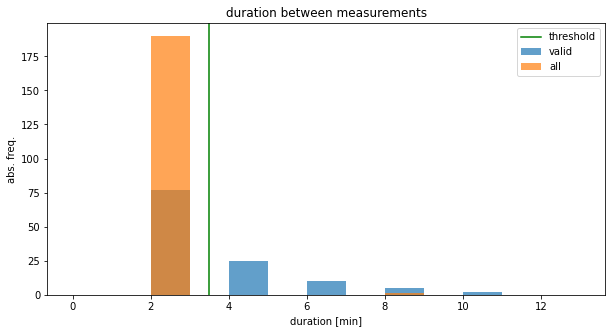

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
bins=np.arange(0, np.max(data.duration), 1)
ax.hist(data[Columns.duration.value],
        bins=bins, alpha=0.7, label='valid')
ax.hist(data[Columns.duration.value + '_all'],
             bins=bins, alpha=0.7, label='all')
ax.axvline(3.5, label='threshold', color='green')
ax.set_title('duration between measurements')
ax.set_xlabel('duration [min]')
ax.set_ylabel('abs. freq.')
ax.legend()
plt.show()

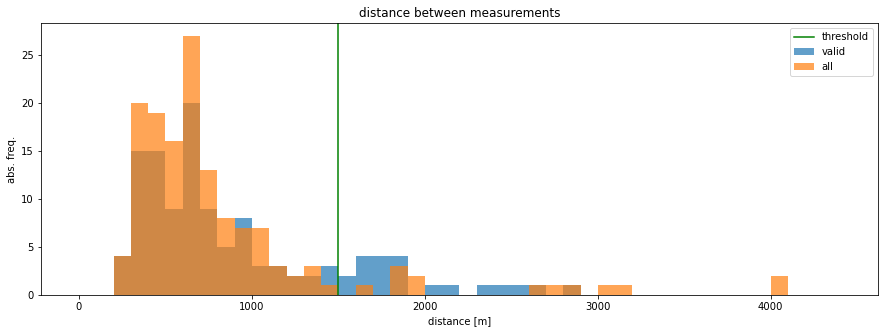

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[15,5])
bins=np.arange(0, np.max(data.dist), 100)
ax.hist(data[Columns.distance.value],
        alpha=0.7, bins=bins, label='valid')
ax.hist(data[Columns.distance.value + '_all'],
             alpha=0.7, bins=bins, label='all')
ax.set_title('distance between measurements')
ax.set_xlabel('distance [m]')
ax.set_ylabel('abs. freq.')
ax.axvline(1500, label='threshold', color='green')
ax.legend()
plt.show()

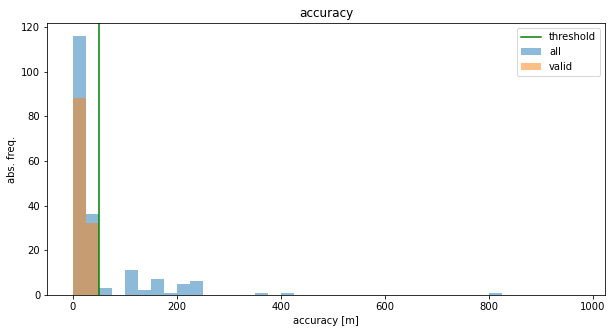

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
bins=np.arange(0, np.max(data[Columns.accuracy.value]), 25)
ax.hist(data[Columns.accuracy.value],
        alpha=0.5, bins=bins, label='all')
ax.hist(data.loc[data[Columns.label.value], Columns.accuracy.value],
        bins=bins, alpha=0.5, label='valid')
ax.set_title('accuracy')
ax.set_xlabel('accuracy [m]')
ax.set_ylabel('abs. freq.')
ax.axvline(50, label='threshold', color='green')
ax.legend()
plt.show()

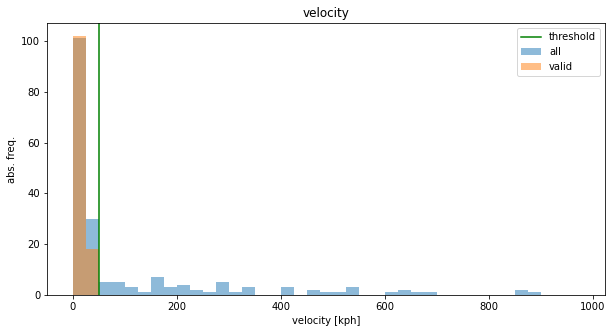

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
bins=np.arange(0, np.max(data[Columns.accuracy.value]), 25)
ax.hist(data[Columns.velocity.value + '_all'],
        alpha=0.5, bins=bins, label='all')
ax.hist(data.loc[data[Columns.label.value], Columns.velocity.value],
        bins=bins, alpha=0.5, label='valid')
ax.set_title('velocity')
ax.set_xlabel('velocity [kph]')
ax.set_ylabel('abs. freq.')
ax.axvline(50, label='threshold', color='green')
ax.legend()
plt.show()

### 2d plot of accuracy vs velocity
for testing manual thresholds

In [10]:
acc_threshold = 46
veloc_threshold = 50

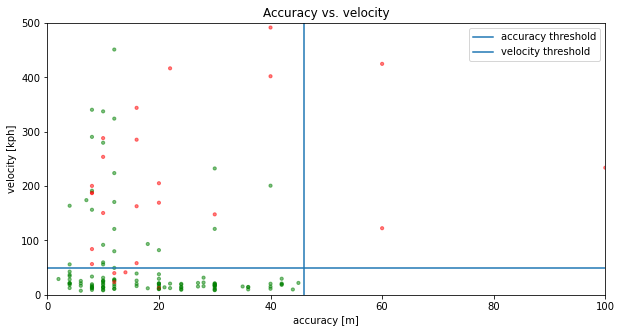

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
colors = ['green' if v else 'red' for v in data[Columns.label.value]]
ax.scatter(data[Columns.accuracy.value], data[Columns.velocity.value + '_all'],
           color=colors, alpha=0.5, s=10)
ax.set_title('Accuracy vs. velocity')
ax.set_xlabel('accuracy [m]')
ax.set_ylabel('velocity [kph]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 500)
ax.axvline(acc_threshold, label='accuracy threshold')
ax.axhline(veloc_threshold, label='velocity threshold')
ax.legend()
plt.show()

---
# visualize API-filtered data
the API uses a model that is created at the end of the notebook.  
Make sure the server has been started, e.g. by running ```./start_service.sh```.

In [12]:
data_json = send_request(
    data=None,             # if none, data is loaded from file before sent to API
    use_model=True,        # switch: use ML model or thresholds
    include_labels=True,   # whether to send labels for evaluation
    verbose=True)          # server verbose mode for testing
gdf = create_geopandas(pd.DataFrame(data_json))

# show result of filtered data
show_map(data=gdf,
         show_points=False,
         show_lines=True,
         valid_only=True)

---
# AI!
The thresholds do a great job already. And generating an appropriate data set is tricky due to the mutual dependency of each waypoint. So this is just a shot in the dark.
Random Forests are too powerful and unnecessecarily slow down the whole pipeline. Due to having just two features a DecisionTree should suffice.

In [13]:
# models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix, f1_score

In [14]:
# for a quick win, this is extracted from the API backend;
# with more time at hand, there should be an integrated solution for both use cases
gdf = create_geopandas(crs=CRS_BERLIN)

collector = []
last_valid_idx = gdf.index[0]
for idx in gdf.iloc[1:].index:
    current_waypoint = gdf.loc[idx]
    if last_valid_idx >= 0:
        pred_waypoint = gdf.loc[last_valid_idx]
    else:
        continue  # if there is no predecessor, waypoint won't be considered as valid
    label = current_waypoint[Columns.label.value]
    accuracy = current_waypoint[Columns.accuracy.value]
    duration = current_waypoint[Columns.time.value] - pred_waypoint[Columns.time.value]
    distance = current_waypoint[Columns.geometry.value].distance(pred_waypoint[Columns.geometry.value])
    velocity = compute_velocity(
        distance=distance,
        duration=duration)
    collector.append([current_waypoint[Columns.lat.value],
                      current_waypoint[Columns.lon.value],
                      accuracy, velocity, label])
    if label:
        last_valid_idx = idx

training_data = pd.DataFrame(collector,
                             columns=[Columns.lat.value,
                                      Columns.lon.value,
                                      Columns.accuracy.value,
                                      Columns.velocity.value,
                                      Columns.label.value])

### train and test split

In [15]:
X_columns = [Columns.accuracy.value, Columns.velocity.value]
X = training_data[X_columns]
y = training_data[Columns.label.value]

# on a real-world example, the split might depend on GPS accuracy,
# i.e. consecutive waypoints should not be part of train and set;
# for now, a simple random split should do the work
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

### model

In [16]:
# model = RandomForestClassifier()
# model = SVC()
model = DecisionTreeClassifier(max_depth=None)

### cross validation

In [17]:
scores = cross_val_score(model, X, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.04


### fit the model

In [18]:
# model.fit(X, y)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_true = y_test

### evaluation

In [19]:
print_evaluation(
    y_true=y_true,
    y_pred=y_pred)

 F1 score: 0.985
 Accuracy: 0.979
Precision: 1.000
   Recall: 0.970


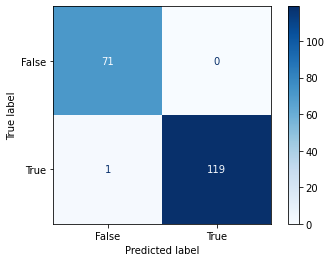

In [20]:
_ = plot_confusion_matrix(model, X, y, cmap='Blues')

### show the decision tree (if one was fitted)
for depth of 2, thresholds can be derived directly from the tree

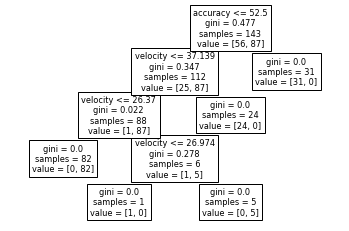

In [21]:
if isinstance(model, DecisionTreeClassifier):
    _ = plot_tree(model, feature_names=X_columns)

### export model
export model for using it in the filtering API

In [22]:
deploy_model = False
if deploy_model:
    filename = 'data/model.mdl'
    pickle.dump(model, open(filename, 'wb'))

### show prediction on map
since the data set is that small, it's kind of a self-fulfilling prophecy for sure. This should align with the result from the API call.

In [23]:
aux = create_geopandas(training_data)

aux[Columns.label.value] = model.predict(X)  # fake labels for visualizing predictions

show_map(data=aux,
         show_points=False,
         show_lines=True,
         valid_only=True)